In [1]:
# Data Set: FD004
# Train trjectories: 248
# Test trajectories: 249
# Conditions: SIX
# Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [2]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [3]:
random.seed(seed)
np.random.seed(seed)

In [4]:
pwd()

'/Users/Shikhar/Desktop/Downloads/CMaps'

In [5]:
dir_path = '/Users/Shikhar/Desktop/Downloads/CMaps/'
train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD004.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [6]:
print(train.shape)
train.head()

(61249, 26)


unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    42.0049     0.8400      100.0  445.00  549.68   
1        1            2    20.0020     0.7002      100.0  491.19  606.07   
2        1            3    42.0038     0.8409      100.0  445.00  548.95   
3        1            4    42.0000     0.8400      100.0  445.00  548.70   
4        1            5    25.0063     0.6207       60.0  462.54  536.10   

       s_3      s_4   s_5  ...    s_12     s_13     s_14     s_15  s_16  s_17  \
0  1343.43  1112.93  3.91  ...  129.78  2387.99  8074.83   9.3335  0.02   330   
1  1477.61  1237.50  9.35  ...  312.59  2387.73  8046.13   9.1913  0.02   361   
2  1343.12  1117.05  3.91  ...  129.62  2387.97  8066.62   9.4007  0.02   329   
3  1341.24  1118.03  3.91  ...  129.80  2388.02  8076.05   9.3369  0.02   328   
4  1255.23  1033.59  7.05  ...  164.11  2028.08  7865.80  10.8366  0.02   305   

   s_18    s_19   s_20     s_21  
0  2212  100.00  10.62   6.3670  
1  2324  100.00  24.37  14.6552  
2  2212  100.00  10.48   6.4213  
3  2212  100.00  10.54   6.4176  
4  1915   84.93  14.03   8.6754  

[5 rows x 26 columns]

In [7]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  320
1        1            2  319
2        1            3  318
3        1            4  317
4        1            5  316

In [8]:
## Baseline Model

In [9]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() # get last row of each engine

In [10]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [11]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.437942286412238, R2:0.722073897506153
test set RMSE:34.59373591136872, R2:0.5974472412019595


In [12]:
## Plotting

In [13]:
# before we start plotting, lets implement the condition specific scaling
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [14]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

In [15]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

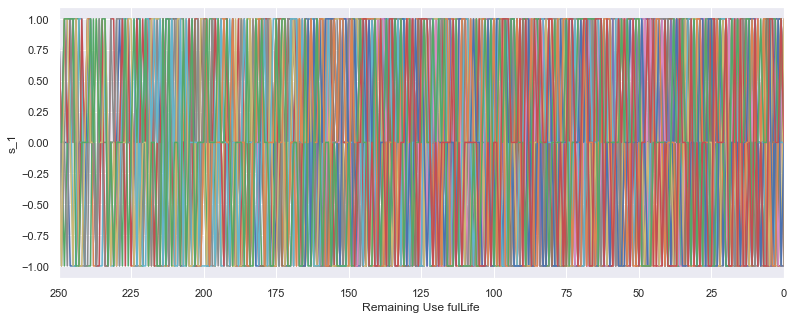

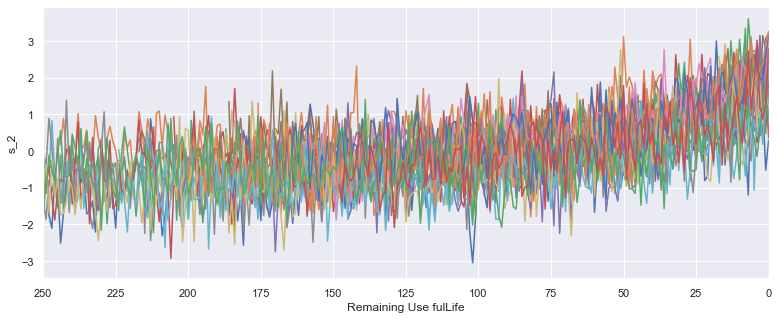

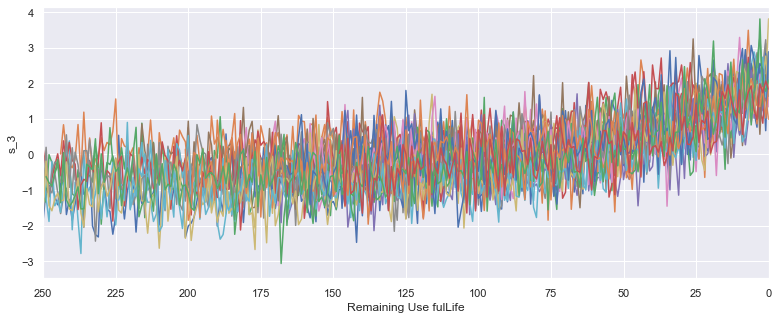

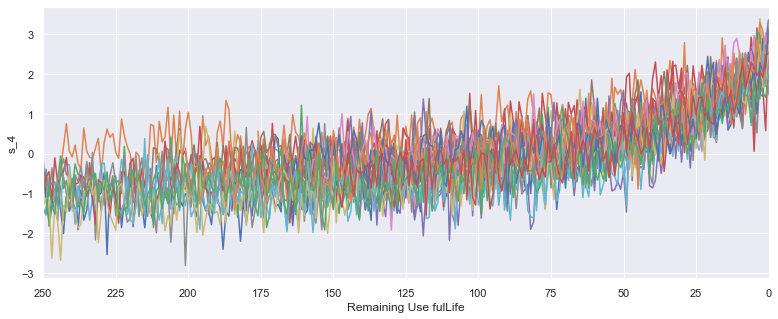

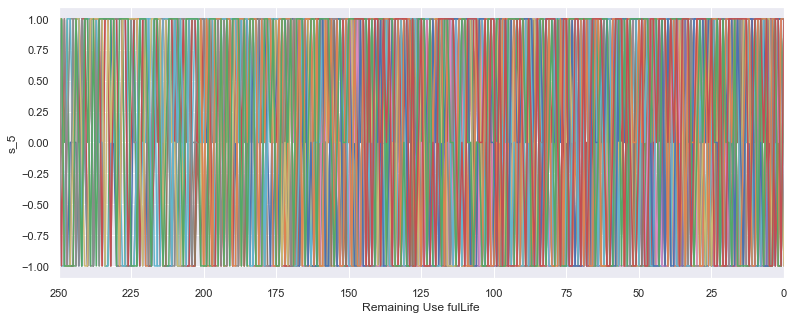

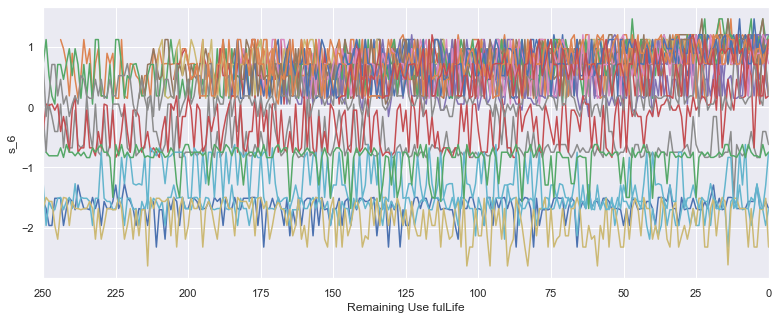

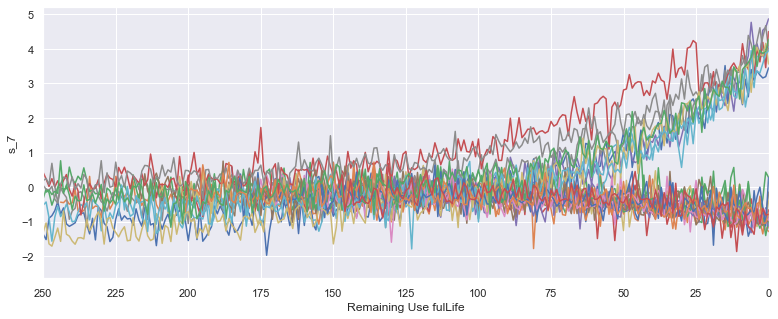

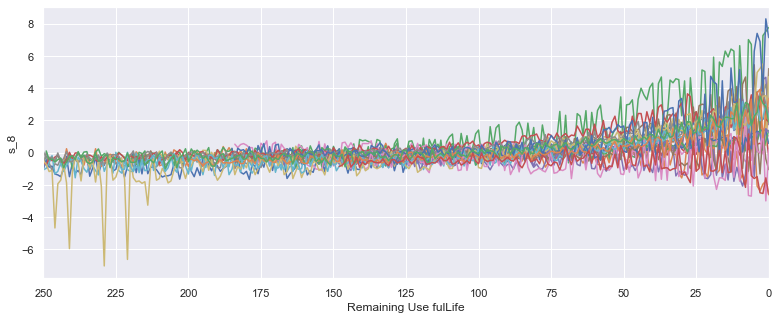

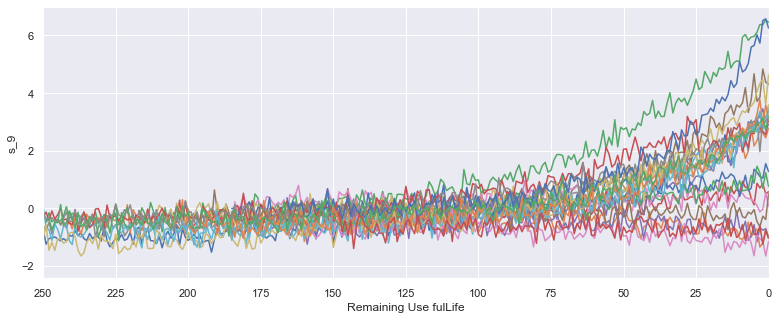

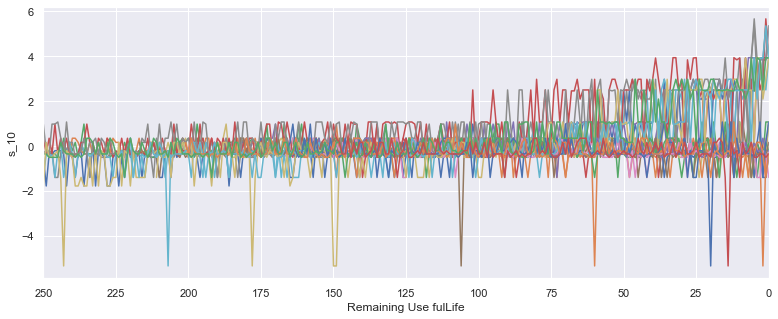

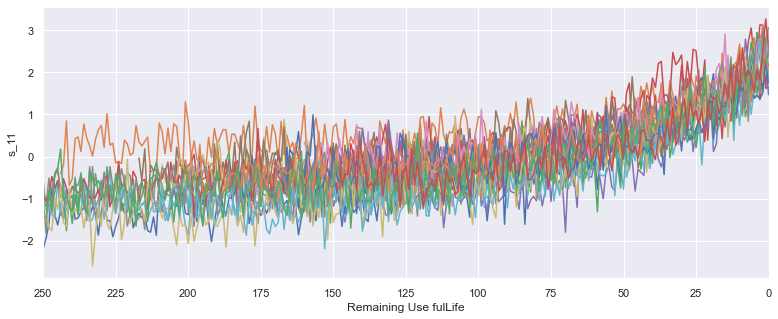

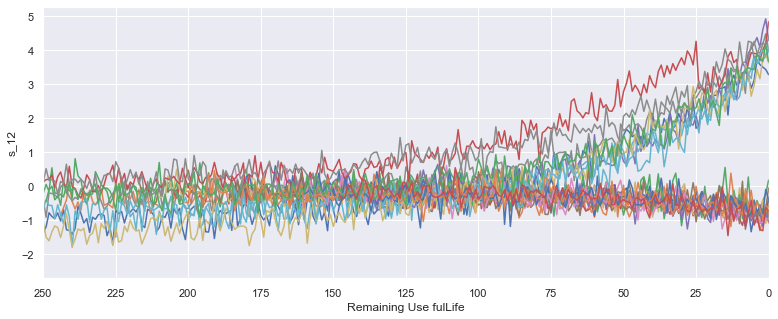

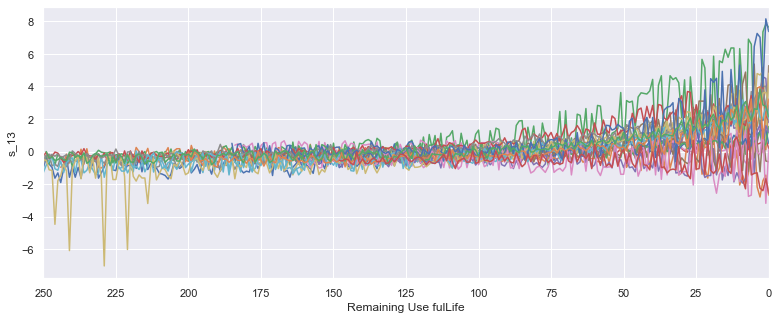

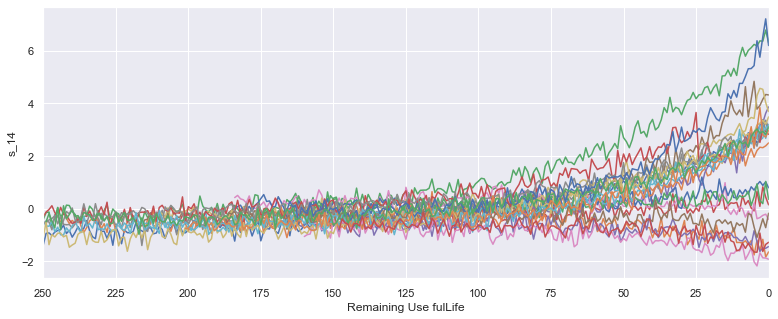

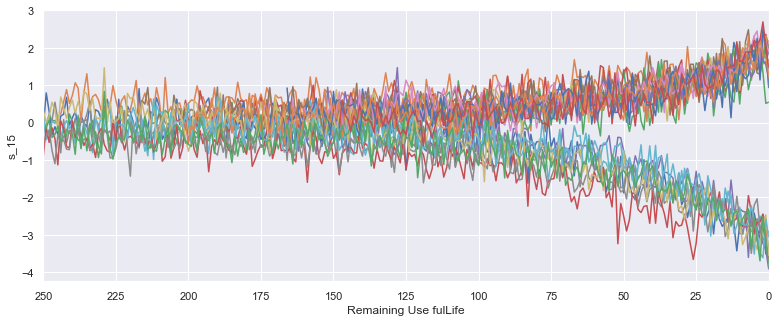

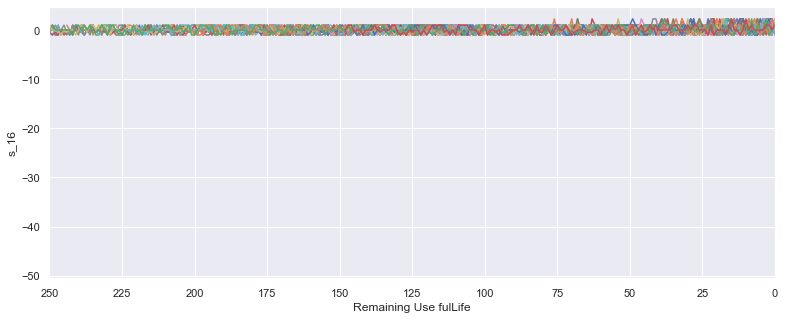

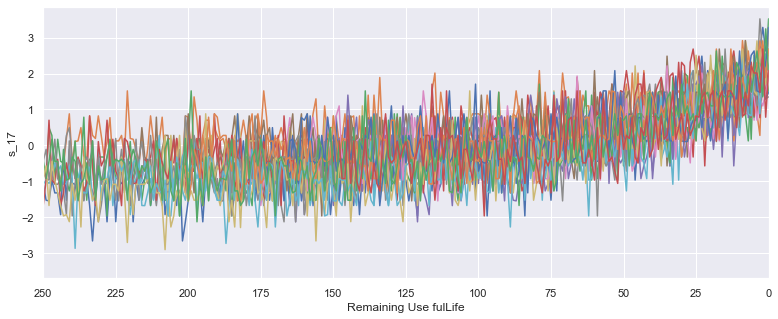

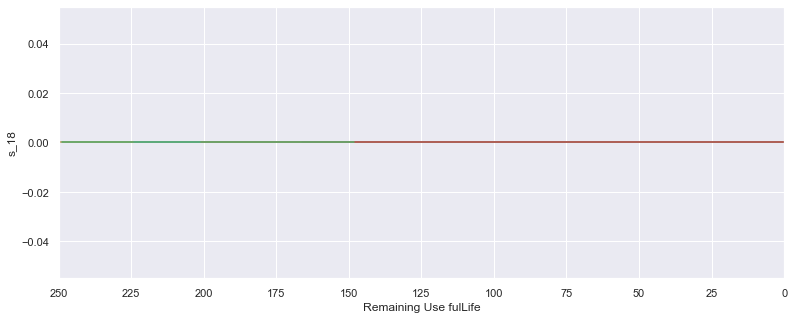

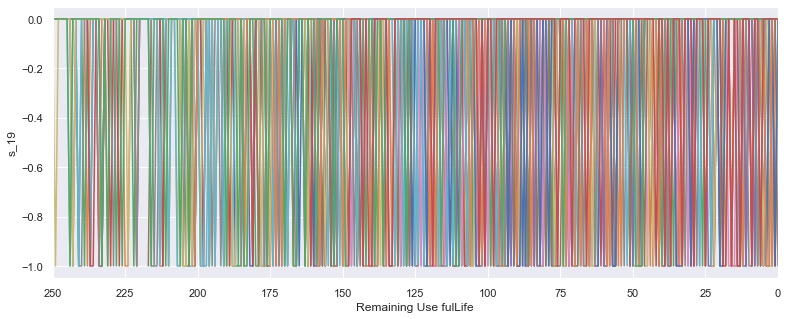

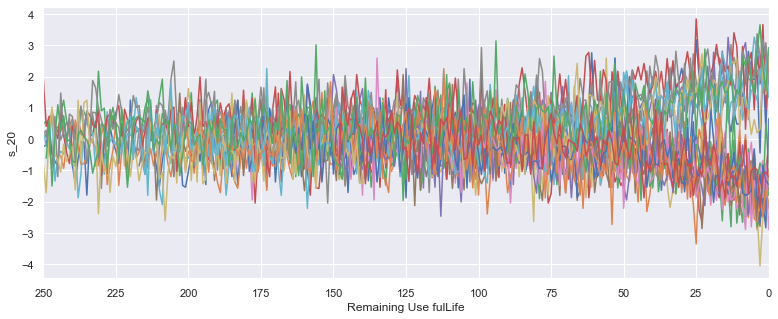

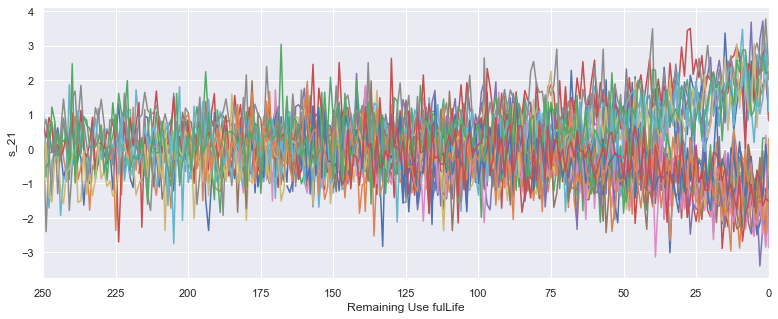

In [16]:
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)

#### Note, useable sensors seem to be ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'], however sensors ['s_8', 's_9', 's_13', 's_14'] might confuse the model as they don't seem to distinguish between the two fault modes very well. Something we'll have to test during model development

In [17]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [20]:
drop_labels = index_names+setting_names+drop_sensors
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [21]:
## Clipped RUL 
y_train_clipped = y_train.clip(upper=125)

# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:27.55543394929027, R2:0.540825616189234
test set RMSE:40.675446222561646, R2:0.4434649410768561


In [22]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
#RF
from sklearn.model_selection import RandomizedSearchCV


In [24]:
from sklearn.ensemble import RandomForestRegressor


In [25]:
#Random Forest Regressor param_dict
n_estimators = [10,20,30,50]
max_depth = [6,8,10,12]
min_samples_split = [60,70,80,100]
min_samples_leaf = [30,40,50,60]
# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
# Create an instance of the random forest regressor
rf_model = RandomForestRegressor()

#RandomSearch
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=0,cv=5)
rf_random.fit(X_train,y_train_clipped)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [6, 8, 10, 12],
                                        'min_samples_leaf': [30, 40, 50, 60],
                                        'min_samples_split': [60, 70, 80, 100],
                                        'n_estimators': [10, 20, 30, 50]})

In [26]:
## Final model

print(rf_random.best_params_)
print(rf_random.best_score_)

# best try

{'n_estimators': 30, 'min_samples_split': 100, 'min_samples_leaf': 30, 'max_depth': 12}
0.7718850051499627


In [27]:
rf = RandomForestRegressor(n_estimators=30,max_features="sqrt", random_state=42,
                           min_samples_leaf=30, min_samples_split=100, 
                           max_depth=12)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:17.954963796885615, R2:0.8050459732736112
test set RMSE:31.463051131351, R2:0.6670112600252449


In [28]:
from xgboost import XGBRegressor

In [29]:
# Number of trees
n_estimators = [70,75,80,85,90,100,120]

# Maximum depth of trees
max_depth = [6,8,9,10]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [20,30,40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [30]:
# Create an instance of the XGBoost
xgb_model = XGBRegressor(learning_rate=0.1)

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train_scaled,y_train_clipped)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:30:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=150, n_estimators=120; total time=  21.9s
[15:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or som

[CV] END max_depth=10, min_samples_leaf=30, min_samples_split=150, n_estimators=75; total time=  12.2s
[15:34:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=8, min_samples_leaf=20, min_samples_split=100, n_estimators=85; total time=  11.1s
[15:34:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[CV] END max_depth=6, min_samples_leaf=20, min_samples_split=150, n_estimators=120; total time=  10.4s
[15:36:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=9, min_samples_leaf=40, min_samples_split=100, n_estimators=70; total time=  10.4s
[15:37:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistak

[CV] END max_depth=6, min_samples_leaf=20, min_samples_split=50, n_estimators=70; total time=   7.2s
[15:39:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   7.1s
[15:39:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenl

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          ma...
                                          max_leaves=None,
                                          min_c

In [31]:
## Final model

print(xgb_random.best_params_)
print(xgb_random.best_score_)

# best try

{'n_estimators': 85, 'min_samples_split': 100, 'min_samples_leaf': 20, 'max_depth': 8}
0.7875083996422528


In [32]:
xgb = XGBRegressor(n_estimators=85,max_features="sqrt", random_state=42,
                           min_samples_leaf=20, min_samples_split=100, 
                           max_depth=8)
xgb.fit(X_train_scaled, y_train_clipped)

# predict and evaluate
y_hat_train = xgb.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = xgb.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

[15:40:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


train set RMSE:13.308103036032486, R2:0.8928985250822085
test set RMSE:31.10518405747468, R2:0.6745431423055639
